# Chapter 11: Training Deep Neural Networks

### Summary and Practical Guidlines
- in this chapter, we have covered a wide range of techniques, and you may be wondering which ones you should use for a **Default DNN Configuration**
- this depends on the task, and there is no clear consensus yet, but the following configuration should generally work just fine: (hyperparameters on the right)
---
- *Kernel initializer*: He initialization
- *Ativation Function*: ELU
- *Normalization*: None if shallow; Batch Norm if deep 
- *Regularization*: Early Stopping (+$l_2$ reg. if needed)
- *Optimizer*: Momentum optimization (or RMSProp or Nadam)
- *Learning rate schedule*: 1cycle
---
- if the neural network is a simple stack of dense layers, then it can self-normalize
- for a **Self-Normalizing Net DNN Configuration**, look below:
---
- *Kernel initializer*: LeCun initialization
- *Ativation Function*: SELU
- *Normalization*: None (self-normalization)
- *Regularization*: Alpha dropout if needed
- *Optimizer*: Momentum optimization (or RMSProp or Nadam)
- *Learning rate schedule*: 1cycle

### Useful Tips
- don't forget to normalize the input features
- always try to reuse parts of a pretrained neural network if you can find one that solves a similar problem
- use unsupervised pretraining if you have a lot of unlabeled data
- use pretraining on an auxiliary task if you have a lot of labeled data for a similar task

### Exceptions to the Previous Guidlines
- if you need a **sparse model**, you can use $l_1$ regularization
- if you need an even sparser model, you can use the TensorFlow Model Optimization Toolkit
---
- if you need a **low-latency model** (performs lightning-fast predictions), you may need to use fewer layers, fold the Batch Normalization layers into the previous layers, and possibly use a faster activation function such as leaky ReLU or just ReLU
- having a sparse model will also help
- finally, you can even reduce the float precision from 32 bits to 16 or even 8 bits
---
- if you are building a **risk-sensitive application**, or inference latency is not very important in your application, you can use MC Dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates

### Concluding Remarks
- with these guidlines, you are now ready to train very deep nets
- by now, you should be convinced that you can go quite a long way with Keras, but there may come a time, however, when you need even more control
- for example, to write a custom loss function or to tweak the training algorithm
- for such cases, you will need to use TensorFlow's lower-level API, as we will learn about in the next chapter

### Exercises
---
- 1) *Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?*
---
- No, all weights should be sampled independently and not have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (all neurons in a given layer are equivalent), and backpropagation will be unable to break it. If every neuron in a layer will always have the same weights, then we're basically working with one neuron per layer, which is much slower and prevents our neural network from convering to a good solution.
---
- 2) *Is it OK to initialize the bias terms to 0?*    
---
- Yes, it is perfeclty fine to initialize the bias terms to zero. Some people, however, like to initialize them just like the weights, but that's okay too as both methods have similar impacts. 
---
- 3) *Name three advantages of the SELU activation function over ReLU.*
---
- Well, unlike ReLU, the SELU activation function can take on negative values, which causes the average output of the neurons in any given layer to be closer to zero than when using ReLU (which never outputs negative values). This helps alleviate the vanishing gradients problem. SELU also always has a nonzero derivative, which avoids the dying neurons (units) issue that can affect ReLU units. Finally, when the conditions are right (the model is sequential, the weights are initialized using LeCun initialization, the inputs are standardized, and there's no incompatible layer or regularization), then the SELU activation function ensures the model is self-normalized, which completely solves the exploding/vanishing gradients problems.
---
- 4) *In which cases would you want to use each of the following activation functions: SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?*
---
- SELU is a good default, but if you need the neural network to be as fast as possible, you can use one of the leaky ReLU variants. The ReLU activation function is very simple, which makes it a preffered option for many people, however, it is generally outperformed by SELU and leaky ReLU. ReLU, though, can output exactly zero, which can prove useful in some cases. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number between -1 and 1, but it us not used much in hidden layers (except in recurrent neural networks). The logistic activation function is also useful in the output layer when you need to estimate a probability (binary classification), but is rarely used in hidden layers. Finally, the softmax activation function is only useful in the output layer to output probabilities for mutually exclusive classes. 
---
- 5) *What may happen if you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer?*
---
- If you set the `momentum` hyperparameter too close to 1 when using an `SGD` optimizer, then the algorithm will likely pick up too much speed, causing it to go right past the global minimum. It will eventually converge, but it will take a very long time. Overall, it will take much longer to converge with a value too close to 1 than a smaller value. 
---
- 6) *Name three ways you can produce a sparse model.*
---
- One way to produce a sparse model (with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply $l_1$ regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
---
- 7) *Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC Dropout?* 
---
- Yes, dropout does slow down training by roughly a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more. 
---
- 8) *Practice training a deep neural network on the CIFAR10 iamge dataset:*
---

*Exercise a): Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [2]:
# necessary imports
import numpy as np
import tensorflow as tf 
from tensorflow import keras 

# mandatory code before model creation
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# creating model
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for i in range(20): # 20 hidden layers
    model.add(keras.layers.Dense(100, # 100 neurons per layer
                                 activation="elu",
                                 kernel_initializer="he_normal"))

*Exercise b): Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

In [4]:
# adding the output layer
model.add(keras.layers.Dense(10, activation="softmax")) # 10 neurons (10 classes) --> we use softmax as classes are exclusive

- we're going to use the Nadam optimizer with a learning rate of 5e-5
- much like Adam is essentially RMSprop with momentum, Nadam is Adam with Nesterov momentum
- Nadam is one of the most popular optimizers for DNNs
---
- **to determine the optimal learning rate, you can experiment with various learning rates on 20 epochs and see which one performs the best on the validation set**

In [5]:
optimizer = keras.optimizers.Nadam(lr=5e-5) # setting the optimizer
model.compile(loss="sparse_categorical_crossentropy", # as this is a classification task
              optimizer=optimizer,
              metrics=["accuracy"]) 

- let's load the CIFAR10 dataset
- we also want to use early (for regularization) stopping, so we need a validation set
- let's use the first 5,000 images of the original training set as the validation set:

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data() # getting the data

In [4]:
# creating a validation set from our training set
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000] # first 5,000 images from training dataset
y_valid = y_train_full[:5000]

In [5]:
X_train.shape # here is how we dictate the input shape 

(45000, 32, 32, 3)

- now let's create the callbacks and train our model:

In [8]:
# creating the necessary callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [20]:
# training the model
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 12s 271us/sample - loss: 4.1776 - accuracy: 0.1661 - val_loss: 2.1598 - val_accuracy: 0.2154
Epoch 2/100
45000/45000 [==============================] - 11s 237us/sample - loss: 2.0466 - accuracy: 0.2472 - val_loss: 1.9641 - val_accuracy: 0.2762
Epoch 3/100
45000/45000 [==============================] - 11s 237us/sample - loss: 1.9367 - accuracy: 0.2904 - val_loss: 1.9173 - val_accuracy: 0.2926
Epoch 4/100
45000/45000 [==============================] - 10s 232us/sample - loss: 1.8654 - accuracy: 0.3196 - val_loss: 1.8039 - val_accuracy: 0.3420
Epoch 5/100
45000/45000 [==============================] - 11s 254us/sample - loss: 1.8025 - accuracy: 0.3436 - val_loss: 1.8685 - val_accuracy: 0.3312
Epoch 6/100
45000/45000 [==============================] - 11s 248us/sample - loss: 1.7535 - accuracy: 0.3629 - val_loss: 1.7461 - val_accuracy: 0.3740
Epoch 7/100
45000/45000 [==============

In [11]:
# evaluating best model on validation set
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

5000/5000 [==============================] - 0s 99us/sample - loss: 1.4917 - accuracy: 0.4736


[1.4917475807189942, 0.4736]

- the model with the lowest validation loss gets about 47% accuracy on the validation set
- it took 56 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch
- let's see if we can improve performance using Batch Normalization:

*Exercise c): Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

In [12]:
# mandatory code before model creation
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# model creation
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization()) # added a BN layer before the first hidden layer
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization()) # added a BN layer after every Dense layer (before the activation function)
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# changed the learning rate to 5e-4 
# experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and chose the one with the best validation performance after 20 epochs
optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

In [13]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 21s 466us/sample - loss: 1.8271 - accuracy: 0.3455 - val_loss: 1.6206 - val_accuracy: 0.4152
Epoch 2/100
45000/45000 [==============================] - 17s 375us/sample - loss: 1.6550 - accuracy: 0.4105 - val_loss: 1.5951 - val_accuracy: 0.4324
Epoch 3/100
45000/45000 [==============================] - 17s 369us/sample - loss: 1.5901 - accuracy: 0.4354 - val_loss: 1.5230 - val_accuracy: 0.4594
Epoch 4/100
45000/45000 [==============================] - 17s 369us/sample - loss: 1.5396 - accuracy: 0.4550 - val_loss: 1.4592 - val_accuracy: 0.4772
Epoch 5/100
45000/45000 [==============================] - 18s 396us/sample - loss: 1.4979 - accuracy: 0.4665 - val_loss: 1.4451 - val_accuracy: 0.4846
Epoch 6/100
45000/45000 [==============================] - 18s 406us/sample - loss: 1.4596 - accuracy: 0.4788 - val_loss: 1.4400 - val_accuracy: 0.4872
Epoch 7/100
45000/45000 [==============

[1.303136032295227, 0.5424]

- the previous model took 56 epochs to reach the lowest validation loss, while this new model with batch normalization took 49 epochs
- the BN layers stabilized training and allowed us to use a much larger learning rate (5e-4), so convergence was faster
---
- this model is much better, with 54% accuracy instead of 47%
- it's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14)
---
- although the model converged faster (took less epochs to reach optimum), each epoch took about 16s instead of 10s (because of the extra computations required by the BN layers)
- so overall, although the number of epochs was reduced, the training time (wall time) was longer

*Exercise d): Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [15]:
# made the necessary adjustements to ensure the network self-normalizes
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal", # using LeCun normal initialization
                                 activation="selu")) # using SELU activation function
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4) # adjusted learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20) # interestingly enough, we are using early stopping for regularization
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

# standardizing the input features
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [16]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 13s 288us/sample - loss: 1.9385 - accuracy: 0.3026 - val_loss: 1.9024 - val_accuracy: 0.3282
Epoch 2/100
45000/45000 [==============================] - 10s 231us/sample - loss: 1.7228 - accuracy: 0.3848 - val_loss: 1.8796 - val_accuracy: 0.3574
Epoch 3/100
45000/45000 [==============================] - 10s 232us/sample - loss: 1.6254 - accuracy: 0.4246 - val_loss: 1.6974 - val_accuracy: 0.4210
Epoch 4/100
45000/45000 [==============================] - 10s 231us/sample - loss: 1.5590 - accuracy: 0.4507 - val_loss: 1.6471 - val_accuracy: 0.4156
Epoch 5/100
45000/45000 [==============================] - 11s 239us/sample - loss: 1.5064 - accuracy: 0.4702 - val_loss: 1.5681 - val_accuracy: 0.4526
Epoch 6/100
45000/45000 [==============================] - 11s 239us/sample - loss: 1.4538 - accuracy: 0.4912 - val_loss: 1.5451 - val_accuracy: 0.4600
Epoch 7/100
45000/45000 [==============

[1.4705164905548096, 0.5098]

- we get about 51% accuracy, which is better than the original model, but not quite as good as the model using batch normalization
- moreover, it took just 33 epochs to reach the best model, which is much faster than both the original model and the BN model, plus each epoch took only 10 seconds
- so this self-normalizing model is by far the fastest model to train (both in terms of epochs and wall time)

*Exercise e): Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [17]:
# self-normalizing model with alpha dropout regularization
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1)) # added alpha dropout regularization
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4) # adjusted learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20) # still using early stopping for regularization (in addition to alpha dropout)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

In [18]:
model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

# not using MC Dropout this first time around
model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 14s 302us/sample - loss: 1.8873 - accuracy: 0.3251 - val_loss: 1.8362 - val_accuracy: 0.3620
Epoch 2/100
45000/45000 [==============================] - 11s 239us/sample - loss: 1.6645 - accuracy: 0.4064 - val_loss: 1.8438 - val_accuracy: 0.3938
Epoch 3/100
45000/45000 [==============================] - 11s 238us/sample - loss: 1.5783 - accuracy: 0.4409 - val_loss: 1.6460 - val_accuracy: 0.4396
Epoch 4/100
45000/45000 [==============================] - 11s 249us/sample - loss: 1.5054 - accuracy: 0.4696 - val_loss: 1.6054 - val_accuracy: 0.4524
Epoch 5/100
45000/45000 [==============================] - 11s 249us/sample - loss: 1.4486 - accuracy: 0.4914 - val_loss: 1.5197 - val_accuracy: 0.4772
Epoch 6/100
45000/45000 [==============================] - 13s 295us/sample - loss: 1.4003 - accuracy: 0.5082 - val_loss: 1.5230 - val_accuracy: 0.4840
Epoch 7/100
45000/45000 [==============

[1.5110135913848877, 0.4926]

- the model reaches about 49% accuracy on the validation set, which is slightly worse than without dropout (51%) 
- with an extensive hyperparameter search, it might be possible to do better (could try different dropout rates and different learning rates), but probably not much better in this case
---
- let's implement MC Dropout by using the `MCAlphaDropout` class:

In [19]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

- now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [20]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers # as previous model is named 'model'
])

- then let's add a couple utility functions
- the first will run the model many times (10 by default) and it will return the mean predicted class probabilities
- the second will use these mean probabilities to predict the most likely class for each instance:

In [21]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

- now let's make predictions for all the instances in the validation set and compute the accuracy:

In [22]:
# mandatory code when making final predictions using MC Dropout
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4922

- we see virtually no accuracy improvement with MC Dropout
- so far, our model with batch normalization has yieled the best performance

*Exercise f): Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# temporary model used to find optimal learning rate
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3) # adjusted learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [26]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

Train on 45000 samples
45000/45000 [==============================] - 3s 64us/sample - loss: nan - accuracy: 0.1372


(9.999999747378752e-06,
 9.999868392944336,
 2.0244507789611816,
 3.46649101802281)

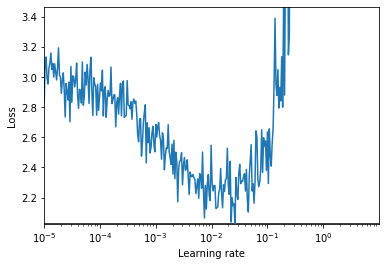

In [28]:
from matplotlib import pyplot as plt

# 1cycle learning rate scheduling (to find the optimal learning rate)
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1)) # using alpha dropout for regularization (no longer using early stopping as well)
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2) # adjusted 'optimal' learning rate
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [31]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [32]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05) # still using scaled data
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 4s 88us/sample - loss: 2.0500 - accuracy: 0.2847 - val_loss: 1.7534 - val_accuracy: 0.3740
Epoch 2/15
45000/45000 [==============================] - 3s 74us/sample - loss: 1.7574 - accuracy: 0.3778 - val_loss: 1.7232 - val_accuracy: 0.4040
Epoch 3/15
45000/45000 [==============================] - 3s 75us/sample - loss: 1.6206 - accuracy: 0.4253 - val_loss: 1.7244 - val_accuracy: 0.4126
Epoch 4/15
45000/45000 [==============================] - 3s 70us/sample - loss: 1.5451 - accuracy: 0.4502 - val_loss: 1.6185 - val_accuracy: 0.4390
Epoch 5/15
45000/45000 [==============================] - 3s 70us/sample - loss: 1.4928 - accuracy: 0.4721 - val_loss: 1.5484 - val_accuracy: 0.4570
Epoch 6/15
45000/45000 [==============================] - 3s 71us/sample - loss: 1.4496 - accuracy: 0.4866 - val_loss: 1.5832 - val_accuracy: 0.4472
Epoch 7/15
45000/45000 [==============================] -

- 1cycle learning rate scheduling allowed us to train the model in just 15 epochs, each taking only 3 seconds (thanks to the larger batch size, which is over 3 times faster than the fastest model we trained so far
- moreover, we improved the model's performance (from 50.8% to 52.8%)
- the batch normalized model reaches a slightly better performance, but it's much slower to train
- overall, this self-normalizing model with 1cycle learning rate schedule is definitely the best bang for our buck